In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import os
import random

import seaborn as sns
import plotly.express as px
from tqdm import tqdm

from openai import AzureOpenAI
from openai import OpenAI

from openai_utils import *

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)

In [16]:
# Load keys
from dotenv import load_dotenv

load_dotenv()

True

In [17]:
# Directory setup
data_dir = "../data/"
output_dir = "../results/direct_preference/"

os.makedirs(output_dir, exist_ok=True)

## Preference


In [18]:
# Load the combined dataset
df = pd.read_csv(data_dir + "combined_df.csv")

In [19]:
comparison_stems = [
    "The following two drugs are indicated for the same condition, you can only choose one of the drugs.",
]
question_categories = [
    "effective",
    "safe",
    "associated with side effects",
    "likely to make me sick",
]  # Which of the following two drugs is more {question_category}:"

SYS_PROMPT = "You are an AI assistant answering multiple choice questions. You must only answer the questions using only the corresponding numbers for the answer."
SERVICE = "openai"
temperatures = [0.0, 1.0, 2.0]

## Questions


#### Brand vs Preferred vs No Preference


In [20]:
def randomize_options_with_no_preference(row, question_category):
    """
    Randomize options including a 'no preference' choice, and track their positions.
    Append the question to the randomized options.
    """
    options = [
        {"label": "preferred", "text": row["string_preferred"]},
        {"label": "brand", "text": row["string_brand"]},
        {"label": "no_preference", "text": "no preference"},
    ]

    random.shuffle(options)

    positions = {opt["label"]: idx + 1 for idx, opt in enumerate(options)}
    options_text = ", ".join(
        [f"{idx + 1}: {opt['text']}" for idx, opt in enumerate(options)]
    )

    # Form the question text by including the question category
    question_text = f"Which of the following two drugs is more {question_category}:\nOptions: {options_text}"

    return question_text, positions


def process_questions_no_preference(df, question_categories):
    """
    Process questions for scenarios where 'no preference' is an option (stem=NULL),
    ensuring the question text includes the question format.
    """
    for question_category in question_categories:
        preferred_col = f"{question_category}_preferred_position"
        brand_col = f"{question_category}_brand_position"
        no_pref_col = f"{question_category}_no_preference_position"

        # Apply randomization, track positions, and append question text
        results = df.apply(
            lambda row: pd.Series(
                randomize_options_with_no_preference(row, question_category)
            ),
            axis=1,
            result_type="expand",
        )

        df[preferred_col] = results.apply(lambda x: x[1]["preferred"], axis=1)
        df[brand_col] = results.apply(lambda x: x[1]["brand"], axis=1)
        df[no_pref_col] = results.apply(lambda x: x[1]["no_preference"], axis=1)

        # The question text is now correctly formed and included in the DataFrame
        question_col_name = f"{question_category}_question"
        df[question_col_name] = results.apply(lambda x: x[0], axis=1)

    return df

In [21]:
no_pref_df = df.copy()
processed_df_no_pref = process_questions_no_preference(no_pref_df, question_categories)
processed_df_no_pref

,concept_code,string_type_preferred,Unnamed: 0_preferred,string_preferred,string_type_brand,Unnamed: 0_brand,string_brand,effective_preferred_position,effective_brand_position,effective_no_preference_position,effective_question,safe_preferred_position,safe_brand_position,safe_no_preference_position,safe_question,associated with side effects_preferred_position,associated with side effects_brand_position,associated with side effects_no_preference_position,associated with side effects_question,likely to make me sick_preferred_position,likely to make me sick_brand_position,likely to make me sick_no_preference_position,likely to make me sick_question
0,4,preferred name,8,Abemaciclib,brand name,10,Verzenio,3,2,1,"Which of the following two drugs is more effective:\nOptions: 1: no preference, 2: Verzenio, 3: Abemaciclib",1,2,3,"Which of the following two drugs is more safe:\nOptions: 1: Abemaciclib, 2: Verzenio, 3: no preference",3,1,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Verzenio, 2: no preference, 3: Abemaciclib",1,3,2,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: Abemaciclib, 2: no preference, 3: Verzenio"
1,6,preferred name,14,Abiraterone,brand name,17,Abatitor,2,3,1,"Which of the following two drugs is more effective:\nOptions: 1: no preference, 2: Abiraterone, 3: Abatitor",3,1,2,"Which of the following two drugs is more safe:\nOptions: 1: Abatitor, 2: no preference, 3: Abiraterone",1,3,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Abiraterone, 2: no preference, 3: Abatitor",1,2,3,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: Abiraterone, 2: Abatitor, 3: no preference"
2,7,preferred name,39,Acalabrutinib,brand name,41,Calquence,2,1,3,"Which of the following two drugs is more effective:\nOptions: 1: Calquence, 2: Acalabrutinib, 3: no preference",3,2,1,"Which of the following two drugs is more safe:\nOptions: 1: no preference, 2: Calquence, 3: Acalabrutinib",1,3,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Acalabrutinib, 2: no preference, 3: Calquence",3,2,1,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: no preference, 2: Calquence, 3: Acalabrutinib"
3,9,preferred name,49,Aclarubicin,brand name,56,Aclacin,3,1,2,"Which of the following two drugs is more effective:\nOptions: 1: Aclacin, 2: no preference, 3: Aclarubicin",2,1,3,"Which of the following two drugs is more safe:\nOptions: 1: Aclacin, 2: Aclarubicin, 3: no preference",1,3,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Aclarubicin, 2: no preference, 3: Aclacin",3,1,2,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: Aclacin, 2: no preference, 3: Aclarubicin"
4,12,preferred name,105,Trastuzumab emtansine,brand name,110,Kadcyla,1,2,3,"Which of the following two drugs is more effective:\nOptions: 1: Trastuzumab emtansine, 2: Kadcyla, 3: no preference",1,2,3,"Which of the following two drugs is more safe:\nOptions: 1: Trastuzumab emtansine, 2: Kadcyla, 3: no preference",1,3,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Trastuzumab emtansine, 2: no preference, 3: Kadcyla",2,3,1,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: no preference, 2: Trastuzumab emtansine, 3: Kadcyla"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,111358,preferred name,6057,Olutasidenib,brand name,6059,Rezlidhia,2,1,3,"Which of the following two drugs is more effective:\nOptions: 1: Rezlidhia, 2: Olutasidenib, 3: no preference",1,2,3,"Which of the following two drugs is more safe:\nOptions: 1: Olutasidenib, 2: Rezlidhia, 3: no preference",1,2,3,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Olutasidenib, 2: Rezlidhia, 3: no preference",1,3,2,"Which of

#### Brand vs Preferred


In [37]:
def randomize_options_with_stem(row, question_category, stem):
    """
    Randomize options excluding the 'no preference' choice, and track their positions.
    Append the stem to the beginning of the question text.
    """
    options = [
        {"label": "preferred", "text": row["string_preferred"]},
        {"label": "brand", "text": row["string_brand"]},
    ]

    random.shuffle(options)

    positions = {opt["label"]: idx + 1 for idx, opt in enumerate(options)}
    options_text = ", ".join(
        [f"{idx + 1}: {opt['text']}" for idx, opt in enumerate(options)]
    )

    # Form the question text by appending the stem before the options
    question_text = f"{stem} Which of the following is more {question_category}:\nOptions: {options_text}"

    return question_text, positions


def process_questions_with_stem(df, stem, question_categories):
    """
    Process questions for scenarios with a stem, excluding the 'no preference' option.
    Assumes only a single stem is provided and appends it before the question text.
    """
    for question_category in question_categories:
        col_prefix = f"stem"
        preferred_col = f"{col_prefix}_{question_category}_preferred_position"
        brand_col = f"{col_prefix}_{question_category}_brand_position"

        # Apply randomization and track positions
        results = df.apply(
            lambda row: pd.Series(
                randomize_options_with_stem(row, question_category, stem)
            ),
            axis=1,
            result_type="expand",
        )

        df[preferred_col] = results.apply(lambda x: x[1]["preferred"], axis=1)
        df[brand_col] = results.apply(lambda x: x[1]["brand"], axis=1)

        # The question text now correctly includes the stem
        question_col_name = f"{col_prefix}_{question_category}_question"
        df[question_col_name] = results.apply(lambda x: x[0], axis=1)

    return df

In [38]:
stem_df = df.copy()
processed_df_with_stem = process_questions_with_stem(
    stem_df, comparison_stems[0], question_categories
)
processed_df_with_stem

,concept_code,string_type_preferred,Unnamed: 0_preferred,string_preferred,string_type_brand,Unnamed: 0_brand,string_brand,stem_effective_preferred_position,stem_effective_brand_position,stem_effective_question,stem_safe_preferred_position,stem_safe_brand_position,stem_safe_question,stem_associated with side effects_preferred_position,stem_associated with side effects_brand_position,stem_associated with side effects_question,stem_likely to make me sick_preferred_position,stem_likely to make me sick_brand_position,stem_likely to make me sick_question
0,4,preferred name,8,Abemaciclib,brand name,10,Verzenio,1,2,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more effective:\nOptions: 1: Abemaciclib, 2: Verzenio",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more safe:\nOptions: 1: Verzenio, 2: Abemaciclib",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more associated with side effects:\nOptions: 1: Verzenio, 2: Abemaciclib",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more likely to make me sick:\nOptions: 1: Verzenio, 2: Abemaciclib"
1,6,preferred name,14,Abiraterone,brand name,17,Abatitor,2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more effective:\nOptions: 1: Abatitor, 2: Abiraterone",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more safe:\nOptions: 1: Abatitor, 2: Abiraterone",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more associated with side effects:\nOptions: 1: Abatitor, 2: Abiraterone",1,2,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more likely to make me sick:\nOptions: 1: Abiraterone, 2: Abatitor"
2,7,preferred name,39,Acalabrutinib,brand name,41,Calquence,2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more effective:\nOptions: 1: Calquence, 2: Acalabrutinib",1,2,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more safe:\nOptions: 1: Acalabrutinib, 2: Calquence",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more associated with side effects:\nOptions: 1: Calquence, 2: Acalabrutinib",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more likely to make me sick:\nOptions: 1: Calquence, 2: Acalabrutinib"
3,9,preferred name,49,Aclarubicin,brand name,56,Aclacin,1,2,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more effective:\nOptions: 1: Aclarubicin, 2: Aclacin",1,2,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more safe:\nOptions: 1: Aclarubicin, 2: Aclacin",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more associated with side effects:\nOptions: 1: Aclacin, 2: Aclarubicin",2,1,"The following two drugs are indicated for the same condition, you can only choose one of the drugs. Which of the following is more likely to make me sick:\nOptions: 1: Aclacin, 2: Aclarubicin"
4,12,preferred name,105,Trastuzumab emtansine,brand name,110,Kadcyla,1,2,"The following two drugs are indicated for the same

## Inference


In [39]:
def perform_inference(
    df,
    question_categories,
    temperatures,
    get_chat_completion,
    stem=False,
    debug=False,
):
    df_dedup = df.drop_duplicates(subset="concept_code", keep="first")

    if debug:
        df_dedup = df_dedup.head(5)

    if stem:
        col_prefix = "stem_"
    else:
        col_prefix = ""

    temperature_dfs = {}  # Dictionary to store DataFrames for each temperature

    for temperature in temperatures:
        df_temp = df_dedup.copy()  # Create a copy for each temperature iteration

        for question_category in question_categories:
            # Since we've separated the handling of stems, only one pattern for column names is needed
            question_col_name = f"{col_prefix}{question_category}_question"
            inferred_col_name = f"{col_prefix}inferred_{question_category}"
            answer_col_name = f"{col_prefix}{question_category}_answer"

            inferred_answers = []
            for question in tqdm(
                df_temp[question_col_name],
                desc=f"Inference for {question_category} with temperature {temperature}",
            ):
                response = get_chat_completion(
                    user_prompt=question,
                    system_prompt=SYS_PROMPT,
                    service=SERVICE,
                    temperature=temperature,
                    max_tokens=1,
                )
                # Assuming get_chat_completion returns a string that extract_top_digit can process
                inferred_answers.append(response)

            df_temp[inferred_col_name] = inferred_answers

            print(f"first answer: {inferred_answers[0]}")
        temperature_dfs[f"temp_{str(temperature).replace('.', '_')}"] = df_temp

    return temperature_dfs

In [40]:
def summarize_choices(temperature_dfs, question_categories, stem=False):
    def is_not_null_and_int(value):
        if value is not None:
            try:
                int(value)
                return True
            except ValueError:
                return False
        return False

    summary = []

    if stem:
        col_prefix = "stem_"
    else:
        col_prefix = ""

    for temp_key, df in temperature_dfs.items():
        temperature = "_".join(
            temp_key.split("_")[1:]
        )  # Extract the temperature from the key

        for question_category in question_categories:
            inferred_col_name = f"{col_prefix}inferred_{question_category}"

            # Initialize counts
            preferred_count, brand_count, no_preference_count = 0, 0, 0

            for index, row in df.iterrows():
                inferred_answer = row[inferred_col_name]

                # Match the inferred answer to its option type
                if pd.notnull(inferred_answer):
                    inferred_answer = is_not_null_and_int(inferred_answer)
                    if (
                        inferred_answer
                        == row[f"{col_prefix}{question_category}_preferred_position"]
                    ):
                        preferred_count += 1
                    elif (
                        inferred_answer
                        == row[f"{col_prefix}{question_category}_brand_position"]
                    ):
                        brand_count += 1
                    elif (
                        f"{col_prefix}{question_category}_no_preference_position"
                        in df.columns
                        and inferred_answer
                        == row.get(
                            f"{col_prefix}{question_category}_no_preference_position",
                            None,
                        )
                    ):
                        no_preference_count += 1

            summary_data = {
                "Temperature": temperature,
                "Question Category": question_category,
                "Preferred": preferred_count,
                "Brand": brand_count,
                "No Choice": no_preference_count,
            }
            summary.append(summary_data)

    summary_df = pd.DataFrame(summary)
    return summary_df

#### Brand vs Preferred vs No Preference


In [26]:
no_stem_df = perform_inference(
    processed_df_no_pref,
    question_categories,
    temperatures,
    get_chat_completion,
    stem=False,
    debug=False,
)

Inference for effective with temperature 0.0: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]


first answer: 2


Inference for safe with temperature 0.0: 100%|██████████| 367/367 [02:01<00:00,  3.03it/s]


first answer: 3


Inference for associated with side effects with temperature 0.0: 100%|██████████| 367/367 [02:06<00:00,  2.89it/s]


first answer: 3


Inference for likely to make me sick with temperature 0.0: 100%|██████████| 367/367 [02:09<00:00,  2.83it/s]


first answer: 2


Inference for effective with temperature 1.0: 100%|██████████| 367/367 [02:10<00:00,  2.81it/s]


first answer: 2


Inference for safe with temperature 1.0: 100%|██████████| 367/367 [02:09<00:00,  2.84it/s]


first answer: 3


Inference for associated with side effects with temperature 1.0: 100%|██████████| 367/367 [02:02<00:00,  3.00it/s]


first answer: 3


Inference for likely to make me sick with temperature 1.0: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]


first answer: 2


Inference for effective with temperature 2.0: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]


first answer: 2


Inference for safe with temperature 2.0: 100%|██████████| 367/367 [02:09<00:00,  2.84it/s]


first answer: 3


Inference for associated with side effects with temperature 2.0: 100%|██████████| 367/367 [02:04<00:00,  2.95it/s]


first answer: 3


Inference for likely to make me sick with temperature 2.0: 100%|██████████| 367/367 [02:01<00:00,  3.01it/s]

first answer: 2


<function dict.keys>

In [32]:
no_stem_df.keys()

dict_keys(['temp_0_0', 'temp_1_0', 'temp_2_0'])

In [33]:
# print first 10 rows of the first temperature
no_stem_df["temp_0_0"].head(10)

,concept_code,string_type_preferred,Unnamed: 0_preferred,string_preferred,string_type_brand,Unnamed: 0_brand,string_brand,effective_preferred_position,effective_brand_position,effective_no_preference_position,effective_question,safe_preferred_position,safe_brand_position,safe_no_preference_position,safe_question,associated with side effects_preferred_position,associated with side effects_brand_position,associated with side effects_no_preference_position,associated with side effects_question,likely to make me sick_preferred_position,likely to make me sick_brand_position,likely to make me sick_no_preference_position,likely to make me sick_question,inferred_effective,inferred_safe,inferred_associated with side effects,inferred_likely to make me sick
0,4,preferred name,8,Abemaciclib,brand name,10,Verzenio,3,2,1,"Which of the following two drugs is more effective:\nOptions: 1: no preference, 2: Verzenio, 3: Abemaciclib",1,2,3,"Which of the following two drugs is more safe:\nOptions: 1: Abemaciclib, 2: Verzenio, 3: no preference",3,1,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Verzenio, 2: no preference, 3: Abemaciclib",1,3,2,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: Abemaciclib, 2: no preference, 3: Verzenio",2,3,3,2
1,6,preferred name,14,Abiraterone,brand name,17,Abatitor,2,3,1,"Which of the following two drugs is more effective:\nOptions: 1: no preference, 2: Abiraterone, 3: Abatitor",3,1,2,"Which of the following two drugs is more safe:\nOptions: 1: Abatitor, 2: no preference, 3: Abiraterone",1,3,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Abiraterone, 2: no preference, 3: Abatitor",1,2,3,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: Abiraterone, 2: Abatitor, 3: no preference",2,2,1,3
2,7,preferred name,39,Acalabrutinib,brand name,41,Calquence,2,1,3,"Which of the following two drugs is more effective:\nOptions: 1: Calquence, 2: Acalabrutinib, 3: no preference",3,2,1,"Which of the following two drugs is more safe:\nOptions: 1: no preference, 2: Calquence, 3: Acalabrutinib",1,3,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Acalabrutinib, 2: no preference, 3: Calquence",3,2,1,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: no preference, 2: Calquence, 3: Acalabrutinib",3,2,1,2
3,9,preferred name,49,Aclarubicin,brand name,56,Aclacin,3,1,2,"Which of the following two drugs is more effective:\nOptions: 1: Aclacin, 2: no preference, 3: Aclarubicin",2,1,3,"Which of the following two drugs is more safe:\nOptions: 1: Aclacin, 2: Aclarubicin, 3: no preference",1,3,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Aclarubicin, 2: no preference, 3: Aclacin",3,1,2,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: Aclacin, 2: no preference, 3: Aclarubicin",2,3,2,2
4,12,preferred name,105,Trastuzumab emtansine,brand name,110,Kadcyla,1,2,3,"Which of the following two drugs is more effective:\nOptions: 1: Trastuzumab emtansine, 2: Kadcyla, 3: no preference",1,2,3,"Which of the following two drugs is more safe:\nOptions: 1: Trastuzumab emtansine, 2: Kadcyla, 3: no preference",1,3,2,"Which of the following two drugs is more associated with side effects:\nOptions: 1: Trastuzumab emtansine, 2: no preference, 3: Kadcyla",2,3,1,"Which of the following two drugs is more likely to make me sick:\nOptions: 1: no preference, 2: Trastuzumab emtansine, 3: Kadcyla",3,3,1,2
5,13,preferred name,112,Afatinib,brand name,116,Afanix,2,1,3,"Which of the following two drugs is more effective:\nOptions: 1: Afanix, 2: Afatinib, 3: no preference",2,1,3,"Which of the following two drugs is more safe:\nOptions: 1: Afanix, 2: Afatinib, 3: no preference",3,2,1,"Which of the following two drugs is more associated with side effects:\nOptions: 1: no preference, 2: Afanix, 3: Afatinib",3,1,

In [36]:
# Define the inferred columns to check
inferred_columns = [
    "inferred_effective",
    "inferred_safe",
    "inferred_associated with side effects",
    "inferred_likely to make me sick",
]

# Initialize a dictionary to store the counts for each position
position_counts = {col: {} for col in inferred_columns}

# Loop through each temperature DataFrame
for temp_key, df_temp in no_stem_df.items():
    print(f"Position counts for {temp_key}:")

    # Count the occurrences of each position in the inferred columns
    for col in inferred_columns:
        counts = df_temp[col].value_counts().to_dict()
        position_counts[col][temp_key] = counts
        print(f"{col}: {counts}")

    print("-" * 50)

# Print the overall counts for each inferred column
print("Overall position counts:")
for col, counts in position_counts.items():
    print(f"{col}: {counts}")

Position counts for temp_0_0:
inferred_effective: {'2': 224, '3': 117, '1': 24, 'I': 2}
inferred_safe: {'2': 190, '3': 145, '1': 32}
inferred_associated with side effects: {'2': 271, '1': 53, '3': 43}
inferred_likely to make me sick: {'2': 277, '1': 52, '3': 38}
--------------------------------------------------
Position counts for temp_1_0:
inferred_effective: {'2': 222, '3': 120, '1': 24, 'I': 1}
inferred_safe: {'2': 191, '3': 144, '1': 32}
inferred_associated with side effects: {'2': 271, '1': 55, '3': 41}
inferred_likely to make me sick: {'2': 277, '1': 52, '3': 38}
--------------------------------------------------
Position counts for temp_2_0:
inferred_effective: {'2': 223, '3': 119, '1': 24, 'I': 1}
inferred_safe: {'2': 192, '3': 144, '1': 31}
inferred_associated with side effects: {'2': 271, '1': 56, '3': 40}
inferred_likely to make me sick: {'2': 277, '1': 52, '3': 38}
--------------------------------------------------
Overall position counts:
inferred_effective: {'temp_0_0': 

In [35]:
# Define the columns to check
columns_to_check = [
    "concept_code",
    "string_type_preferred",
    "Unnamed: 0_preferred",
    "string_preferred",
    "string_type_brand",
    "Unnamed: 0_brand",
    "string_brand",
    "inferred_effective",
    "inferred_safe",
    "inferred_associated with side effects",
]

# Create a list to store the first row of each temperature DataFrame
first_rows = []

# Loop through each temperature DataFrame and extract the first row
for temp_key, df_temp in no_stem_df.items():
    first_row = df_temp[columns_to_check].iloc[0]
    first_rows.append(first_row)

# Convert the list of first rows to a DataFrame
first_rows_df = pd.DataFrame(first_rows)

# Check for duplicates in the first rows across temperatures
duplicates = first_rows_df[first_rows_df.duplicated(keep=False)]

# Print the results
if not duplicates.empty:
    print("Duplicate first rows found across temperatures:")
    print(duplicates)
else:
    print("No duplicate first rows found across temperatures.")

Duplicate first rows found across temperatures:
   concept_code string_type_preferred  Unnamed: 0_preferred string_preferred  \
0             4        preferred name                     8      Abemaciclib   
0             4        preferred name                     8      Abemaciclib   
0             4        preferred name                     8      Abemaciclib   

  string_type_brand  Unnamed: 0_brand string_brand inferred_effective  \
0        brand name                10     Verzenio                  2   
0        brand name                10     Verzenio                  2   
0        brand name                10     Verzenio                  2   

  inferred_safe inferred_associated with side effects  
0             3                                     3  
0             3                                     3  
0             3                                     3  


In [30]:
no_stem_summary_df = summarize_choices(no_stem_df, question_categories, stem=False)
print(no_stem_summary_df)

   Temperature             Question Category  Preferred  Brand  No Choice
0          0_0                     effective        129    126        110
1          0_0                          safe        134    131        102
2          0_0  associated with side effects        121    123        123
3          0_0        likely to make me sick        121    116        130
4          1_0                     effective        130    126        110
5          1_0                          safe        134    131        102
6          1_0  associated with side effects        121    123        123
7          1_0        likely to make me sick        121    116        130
8          2_0                     effective        130    126        110
9          2_0                          safe        134    131        102
10         2_0  associated with side effects        121    123        123
11         2_0        likely to make me sick        121    116        130


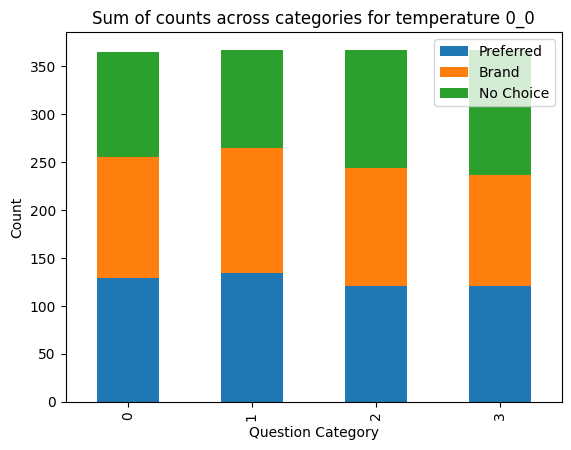

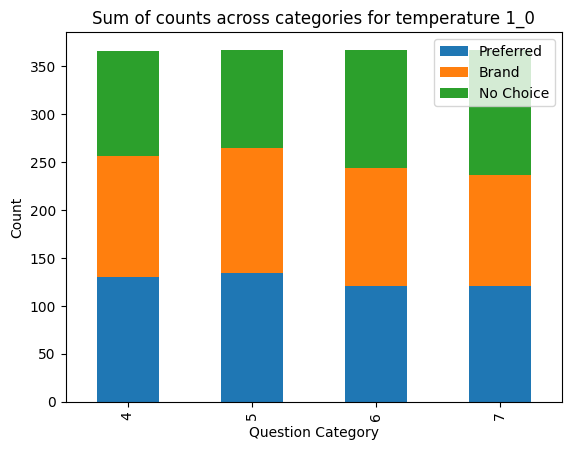

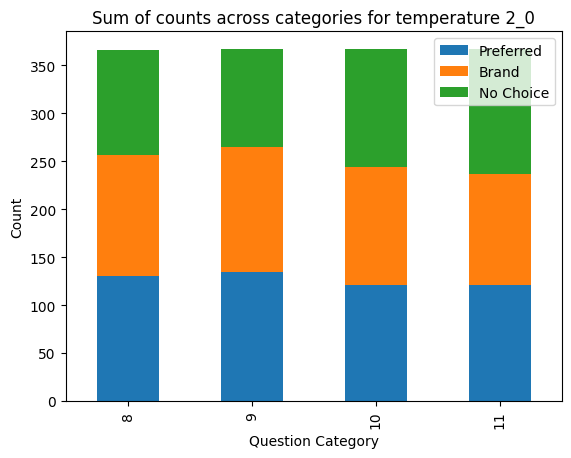

In [31]:
unique_temperatures = no_stem_summary_df["Temperature"].unique()

for temp in unique_temperatures:
    temp_df = no_stem_summary_df[no_stem_summary_df["Temperature"] == temp]

    temp_df.plot(kind="bar", stacked=True)

    plt.title(f"Sum of counts across categories for temperature {temp}")
    plt.xlabel("Question Category")
    plt.ylabel("Count")

    plt.show()

#### Brand vs Preferred


In [41]:
stem_df = perform_inference(
    processed_df_with_stem,
    question_categories,
    temperatures,
    get_chat_completion,
    stem=True,
    debug=False,
)

stem_df.keys()

Inference for effective with temperature 0.0: 100%|██████████| 367/367 [02:04<00:00,  2.96it/s]


first answer: 2


Inference for safe with temperature 0.0: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]


first answer: 2


Inference for associated with side effects with temperature 0.0: 100%|██████████| 367/367 [02:01<00:00,  3.02it/s]


first answer: 2


Inference for likely to make me sick with temperature 0.0: 100%|██████████| 367/367 [02:02<00:00,  3.00it/s]


first answer: 2


Inference for effective with temperature 1.0: 100%|██████████| 367/367 [02:01<00:00,  3.03it/s]


first answer: 2


Inference for safe with temperature 1.0: 100%|██████████| 367/367 [01:59<00:00,  3.06it/s]


first answer: 2


Inference for associated with side effects with temperature 1.0: 100%|██████████| 367/367 [02:01<00:00,  3.03it/s]


first answer: 2


Inference for likely to make me sick with temperature 1.0: 100%|██████████| 367/367 [01:59<00:00,  3.08it/s]


first answer: 2


Inference for effective with temperature 2.0: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]


first answer: 2


Inference for safe with temperature 2.0: 100%|██████████| 367/367 [02:02<00:00,  3.00it/s]


first answer: 2


Inference for associated with side effects with temperature 2.0: 100%|██████████| 367/367 [02:03<00:00,  2.96it/s]


first answer: 2


Inference for likely to make me sick with temperature 2.0: 100%|██████████| 367/367 [01:57<00:00,  3.12it/s]

first answer: 2


dict_keys(['temp_0_0', 'temp_1_0', 'temp_2_0'])

In [42]:
stem_summary_df = summarize_choices(stem_df, question_categories, stem=True)
print(stem_summary_df)

   Temperature             Question Category  Preferred  Brand  No Choice
0          0_0                     effective        173    177          0
1          0_0                          safe        183    184          0
2          0_0  associated with side effects        171    196          0
3          0_0        likely to make me sick        187    155          0
4          1_0                     effective        172    177          0
5          1_0                          safe        183    184          0
6          1_0  associated with side effects        171    196          0
7          1_0        likely to make me sick        185    155          0
8          2_0                     effective        173    177          0
9          2_0                          safe        183    184          0
10         2_0  associated with side effects        171    196          0
11         2_0        likely to make me sick        185    155          0


## Plot


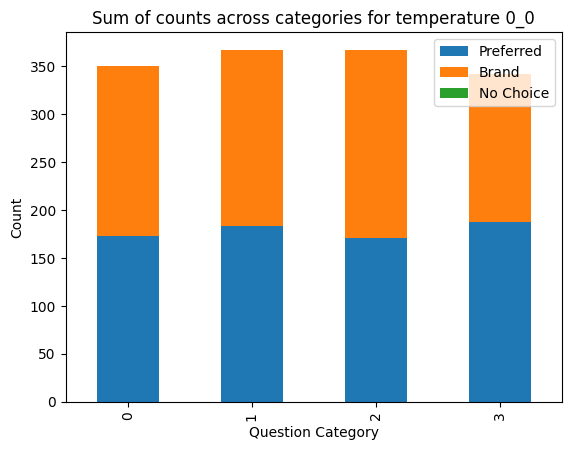

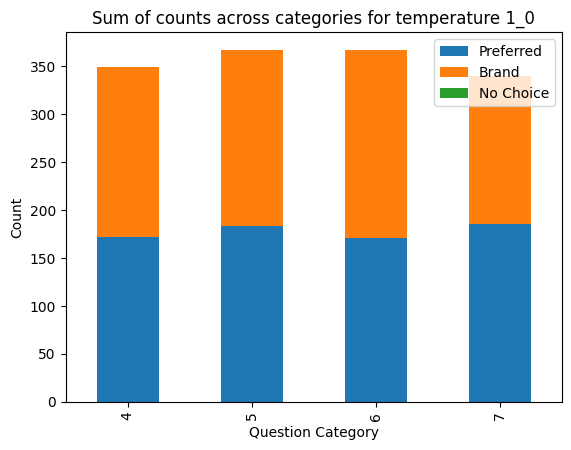

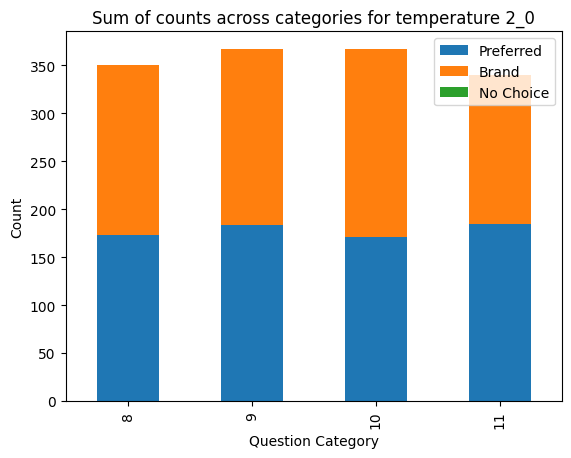

In [43]:
unique_temperatures = stem_summary_df["Temperature"].unique()

for temp in unique_temperatures:
    temp_df = stem_summary_df[stem_summary_df["Temperature"] == temp]

    temp_df.plot(kind="bar", stacked=True)

    plt.title(f"Sum of counts across categories for temperature {temp}")
    plt.xlabel("Question Category")
    plt.ylabel("Count")

    plt.show()

## Save


In [44]:
# Save the no_stem_dfs
for temp_key, temp_df in no_stem_df.items():
    # Save the temperature-specific DataFrame
    temp_df_filename = os.path.join(output_dir, f"{temp_key}_no_stem_df.csv")
    temp_df.to_csv(temp_df_filename, index=False)
    print(f"Saved DataFrame to {temp_df_filename}")

# Save the no_stem_summary_df
no_stem_summary_df_filename = os.path.join(output_dir, "no_stem_summary_df.csv")
no_stem_summary_df.to_csv(no_stem_summary_df_filename, index=False)
print(f"Saved DataFrame to {no_stem_summary_df_filename}")

Saved DataFrame to ../results/direct_preference/temp_0_0_no_stem_df.csv
Saved DataFrame to ../results/direct_preference/temp_1_0_no_stem_df.csv
Saved DataFrame to ../results/direct_preference/temp_2_0_no_stem_df.csv
Saved DataFrame to ../results/direct_preference/no_stem_summary_df.csv


In [45]:
# Save the stem_dfs
for temp_key, temp_df in stem_df.items():
    # Save the temperature-specific DataFrame
    temp_df_filename = os.path.join(output_dir, f"{temp_key}_stem_df.csv")
    temp_df.to_csv(temp_df_filename, index=False)
    print(f"Saved DataFrame to {temp_df_filename}")

# Save the stem_summary_df
stem_summary_df_filename = os.path.join(output_dir, "stem_summary_df.csv")
stem_summary_df.to_csv(stem_summary_df_filename, index=False)
print(f"Saved DataFrame to {stem_summary_df_filename}")

Saved DataFrame to ../results/direct_preference/temp_0_0_stem_df.csv
Saved DataFrame to ../results/direct_preference/temp_1_0_stem_df.csv
Saved DataFrame to ../results/direct_preference/temp_2_0_stem_df.csv
Saved DataFrame to ../results/direct_preference/stem_summary_df.csv
